# Version information

In [1]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: April 27, 2023
Pyleecan version:1.5.0
SciDataTool version:2.5.0


# How to compute currents, voltage and torque using the Electrical Module

This tutorial explains how to use the Electrical Module to compute currents, voltage and torque, using a simple **electrical equivalent circuit**. The idea is to provide insight on how to implement other methods.

The reference used to validate this tutorial is: Z. Yang, M. Krishnamurthy and I. P. Brown, "Electromagnetic and vibrational characteristic of IPM over full torque-speed range," 2013 International Electric Machines & Drives Conference, Chicago, IL, 2013, pp. 295-302, doi: 10.1109/IEMDC.2013.6556267.

## Machine and Simulation definition
This tutorial use the machine IPMSM_A (Prius 2004) defined in the "[How to define a machine](https://pyleecan.org/01_tuto_Machine.html)" tutorial. The configuration is similar to the one used in the "[How to set the Operating Point](https://pyleecan.org/04_tuto_Operating_point.html)" tutorial.

<IPython.core.display.Javascript object>


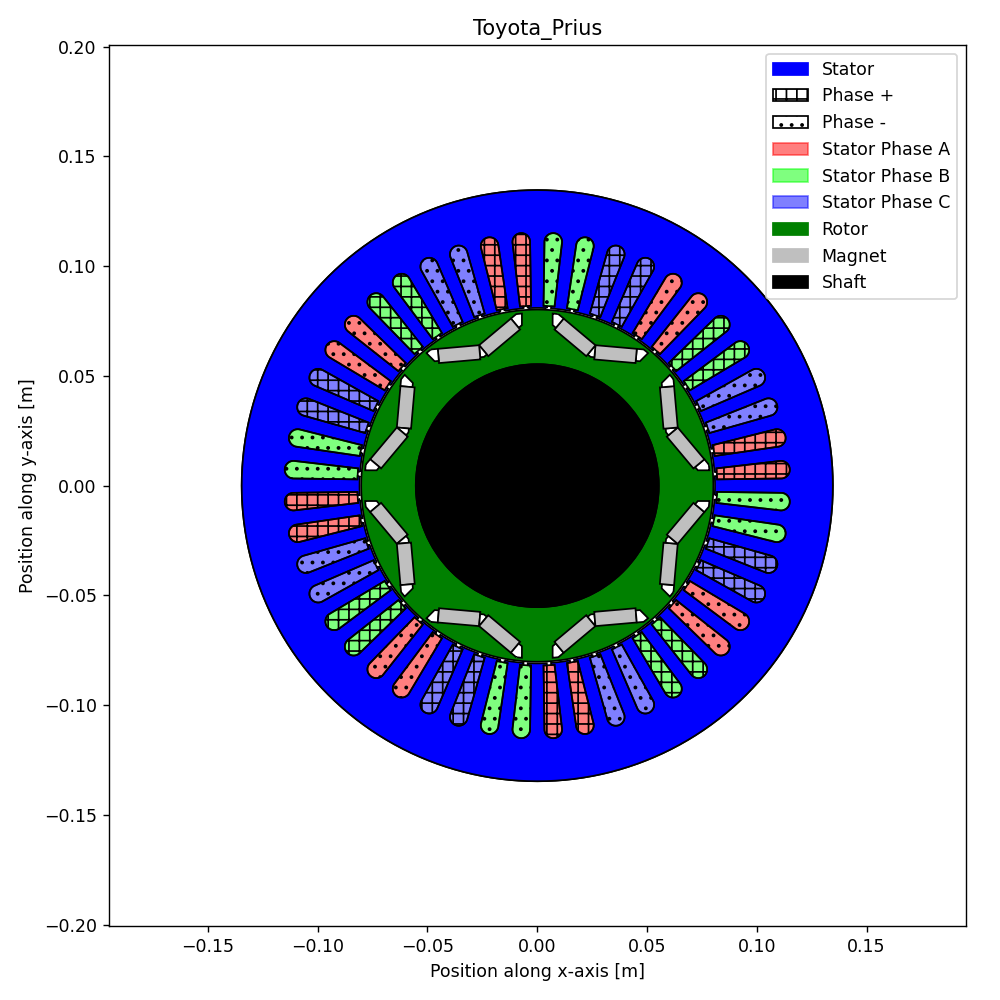

In [3]:
%matplotlib notebook
# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
fig, ax = Toyota_Prius.plot()

## Electrical Equivalent Circuit (EEC)
The electrical module is defined with the object [**EEC_PMSM**](http://pyleecan.org/pyleecan.Classes.EEC_PMSM.html) that correspond to the **electrical equivalent circuit** for synchronous machine from "Advanced Electrical Drives, analysis, modeling, control", Rik de doncker, Duco W.J. Pulle, Andre Veltman, Springer edition, is then used for the computation of Ud/Uq or Id/Iq (see schematics hereafter). 

To compute the parameters of the EEC, you must first set a Magnetic model to compute the flux linkage. In this example we use a  [**MagFEMM**](http://pyleecan.org/pyleecan.Classes.MagFEMM.html) object to compute the flux linkage and the magnetic inductances using FEMM simulations (with symmetries and number of time steps). For the flux linkage computation, the currents are set to 0 \[A\].

Once the parameter of the EEC are known, the voltage can be computed. The electrical torque is then computed according to the formula: $T_{em}=\frac{P-RI^2}{\Omega}$, where $P$ is the magnetic power $P=\frac{q_s}{2}\Re(VI^*)$

                 <---                               --->
     -----R-----wsLqIq----              -----R-----wsLdId----
    |                     |            |                     |
    |                     |            |                    BEMF
    |                     |            |                     |
     ---------Id----------              ---------Iq----------
             
             --->                               ---> 
              Ud                                 Uq

In [4]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.Electrical import Electrical
from pyleecan.Classes.EEC_PMSM import EEC_PMSM
from pyleecan.Classes.MagFEMM import MagFEMM

# Initialization of the Simulation
simu = Simu1(name="tuto_elec", machine=Toyota_Prius)
# Definition of the Electrical Equivalent Circuit
eec = EEC_PMSM(  # No parameter enforced => compute all
    fluxlink=MagFEMM(is_periodicity_a=True, T_mag=60),  # Magnetic model to compute fluxlinkage
)
# The Electrical module is defined with the EEC
simu.elec = Electrical(eec=eec)

# Run only Electrical module
simu.mag = None
simu.force = None
simu.struct = None

## Defining starting point with InputElec or InputCurrent

The starting point of the simulation is defined with [**InputVoltage**](http://pyleecan.org/pyleecan.Classes.InputVoltage.html) or [**InputCurrent**](http://pyleecan.org/pyleecan.Classes.InputCurrent.html). These objects will create an [**OutElec**](http://pyleecan.org/pyleecan.Classes.OutElec.html) object and initialize it with the provided values for Id/Iq, and/or Ud/Uq. [**InputCurrent**](http://pyleecan.org/pyleecan.Classes.InputCurrent.html) enables to define in several ways the starting point (see "[How to set the Operating Point](https://pyleecan.org/04_tuto_Operating_point.html)").

Note that Id/Iq are required to accurately compute the magnetic inductances, so that if only Ud/Uq is provided, a current Id=1A and Iq=1A will be used for the computation of Ld and Lq. A more satisfactory method would be to compute a map of Ld and Lq over Id/Iq with the [**LUTdq**](http://pyleecan.org/pyleecan.Classes.LUTdq.html) object.

In [5]:
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from numpy import sqrt, exp, pi

# Definition of a sinusoidal current
simu.input = InputCurrent()

I0_rms = 250/sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  # Maximum Torque Per Amp

simu.input.OP = OPdq(N0 = 2000)
simu.input.OP.set_I0_Phi0(I0_rms, Phi0)

simu.input.Nt_tot = 50 # Number of time steps
simu.input.Na_tot = 2048 # Spatial discretization

(simu.input.OP.Id_ref,simu.input.OP.Iq_ref)

(-135.4188051049254, 113.62986941801093)

## Running the simulation and postprocessings

In [6]:
out = simu.run()

[16:14:49] Starting running simulation tuto_elec (machine=Toyota_Prius)
[16:14:49] Starting Electric module
[16:14:49] Starting running simulation tuto_elec_FluxLinkFEMM (machine=Toyota_Prius)
[16:14:49] Starting Magnetic module
[16:14:50] Solving time steps: 0%
[16:14:58] Solving time steps: 25%
[16:15:05] Solving time steps: 50%
[16:15:10] Solving time steps: 75%
[16:15:16] Solving time step: 100%
[16:15:16] End of simulation tuto_elec_FluxLinkFEMM
[16:15:16] Starting running simulation tuto_elec_FluxLinkFEMM_FluxLinkFEMM (machine=Toyota_Prius)
[16:15:16] Starting Magnetic module
[16:15:17] Solving time steps: 0%
[16:15:25] Solving time steps: 25%
[16:15:33] Solving time steps: 50%
[16:15:40] Solving time steps: 75%
[16:15:47] Solving time step: 100%
[16:15:47] End of simulation tuto_elec_FluxLinkFEMM_FluxLinkFEMM
[16:15:47] End of simulation tuto_elec


In [7]:
# Print voltage and torque
print("Ud: "+str(out.elec.OP.Ud_ref))
print("Uq: "+str(out.elec.OP.Uq_ref))
print("Tem: "+str(out.elec.Tem_av))

# Electrical Equivalent Circuit parameters are stored in:
print("\nLd: "+str(out.elec.eec.Ld))
print("Lq: "+str(out.elec.eec.Lq))
print("R1: "+str(out.elec.eec.R1))

Ud: -201.40443033554803
Uq: -12.313080032430975
Tem: 353.7141872050232

Ld: 0.0011908433790078954
Lq: 0.0020622123849967674
R1: 0.03778895717396608


<IPython.core.display.Javascript object>


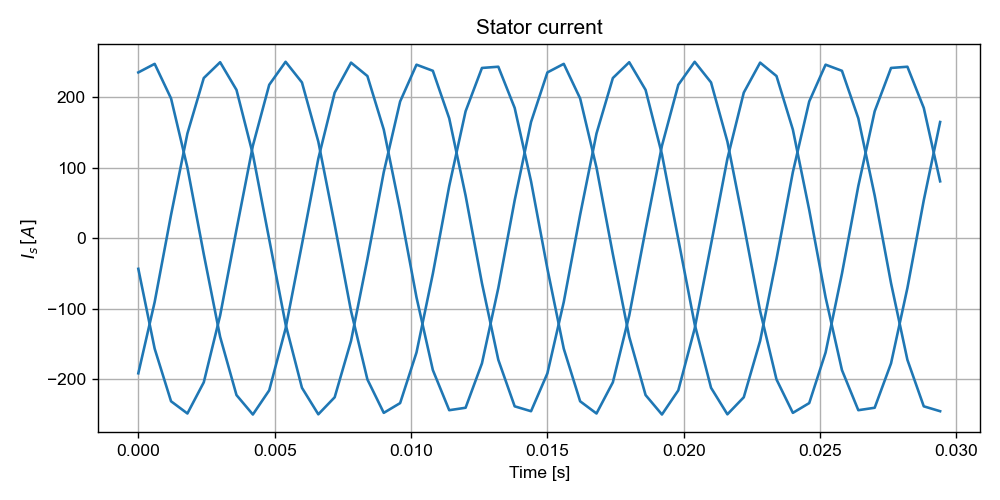

In [8]:
# Plot the currents
out.elec.get_Is().plot_2D_Data("time", "phase")

<IPython.core.display.Javascript object>


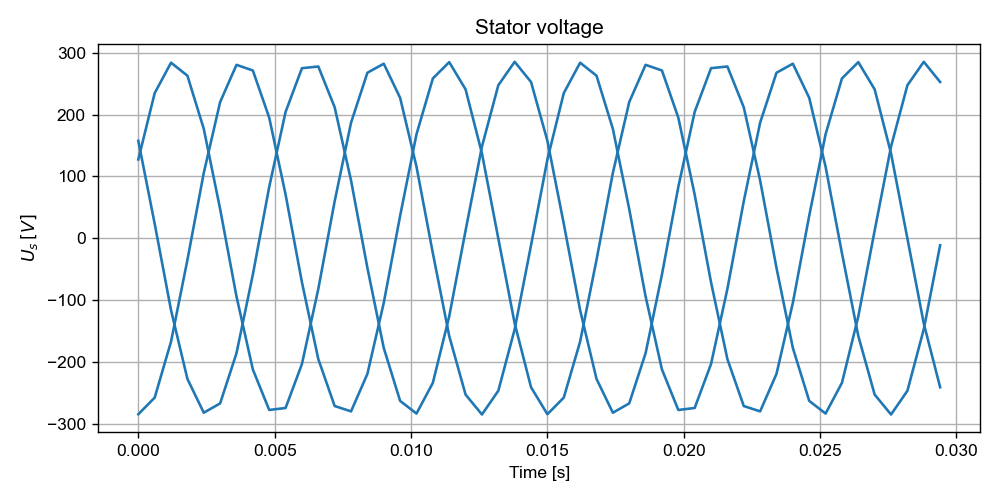

In [9]:
# Plot the voltages
out.elec.get_Us().plot_2D_Data("time", "phase")

## Iterating on several Operating Points
Reference torque and current angle vector are:

In [10]:
from numpy import linspace, array, pi
Tem_av_ref = array([79, 125, 160, 192, 237, 281, 319, 343, 353, 332, 266, 164, 22]) # Yang et al, 2013
Phi0_ref = linspace(60 * pi / 180, 180 * pi / 180, Tem_av_ref.size)
N_simu = Tem_av_ref.size

The multisimulation is similar to the one described in "[How to set the Operating Point](https://pyleecan.org/04_tuto_Operating_Point.html)", except that we are now computing the electrical torque instead of the magnetic torque.

In [11]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from pyleecan.Classes.DataKeeper import DataKeeper
from numpy import zeros, ones, linspace, array, sqrt, arange

simu2 = simu.copy()
# Enforce the EEC parameters from previous run
simu2.elec.eec = out.elec.eec

# Define the Variable speed simulation
varload = VarLoadCurrent()
simu2.var_simu = varload

# Creating the Operating point matrix
OP_matrix = zeros((N_simu,4))

# Set N0 = 2000 [rpm] for all simulation
OP_matrix[:,0] = 2000 * ones((N_simu))

# Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
OP_matrix[:,1] = I0_rms * ones((N_simu)) 

# Set Phi0 from 60° to 180°
OP_matrix[:,2] = Phi0_ref

# Set reference torque from Yang et al, 2013
OP_matrix[:,3] = Tem_av_ref
varload.set_OP_array(OP_matrix, "N0", "I0", "Phi0", "Tem")
print(OP_matrix)

# Add DataKeeper to track I0/Phi0/Tem
I0_dk = DataKeeper(
    name="Stator current rms amplitude",
    symbol="I0",
    unit="Arms",
    keeper="lambda output: output.elec.OP.get_I0_Phi0()['I0']",
)
Phi0_dk = DataKeeper(
    name="Stator current phase",
    symbol="Phi0",
    unit="rad",
    keeper="lambda output: output.elec.OP.get_I0_Phi0()['Phi0']",
)
Tem_dk = DataKeeper(
    name="Computed torque",
    symbol="Tem_av",
    unit="rad",
    keeper="lambda output: output.elec.Tem_av",
)
simu2.var_simu.datakeeper_list = [I0_dk, Phi0_dk, Tem_dk]

[[ 2.00000000e+03  8.83883476e+01  1.53093109e+02  7.90000000e+01]
 [ 2.00000000e+03  6.04611907e+01  1.66115756e+02  1.25000000e+02]
 [ 2.00000000e+03  3.06969510e+01  1.74091060e+02  1.60000000e+02]
 [ 2.00000000e+03  1.08244507e-14  1.76776695e+02  1.92000000e+02]
 [ 2.00000000e+03 -3.06969510e+01  1.74091060e+02  2.37000000e+02]
 [ 2.00000000e+03 -6.04611907e+01  1.66115756e+02  2.81000000e+02]
 [ 2.00000000e+03 -8.83883476e+01  1.53093109e+02  3.19000000e+02]
 [ 2.00000000e+03 -1.13629869e+02  1.35418805e+02  3.43000000e+02]
 [ 2.00000000e+03 -1.35418805e+02  1.13629869e+02  3.53000000e+02]
 [ 2.00000000e+03 -1.53093109e+02  8.83883476e+01  3.32000000e+02]
 [ 2.00000000e+03 -1.66115756e+02  6.04611907e+01  2.66000000e+02]
 [ 2.00000000e+03 -1.74091060e+02  3.06969510e+01  1.64000000e+02]
 [ 2.00000000e+03 -1.76776695e+02  2.16489014e-14  2.20000000e+01]]


In [12]:
# Run multisimulation
Xout = simu2.run()

[16:16:09] Starting running simulation tuto_elec (machine=Toyota_Prius)
[16:16:09] Computing reference simulation for Variable Load
[16:16:09] Starting Electric module
[16:16:09] Variable Load Reference Results: I0=176.8 [Arms], Phi0=1.047 [rad], Tem_av=-284.9 [rad], N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms], Tem_av_ref=79 [N.m]
[===                                               ]   7%
[16:16:09] Running simulation 1/13 with N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms]
[16:16:09] Simulation matches reference one: Skipping computation
[16:16:09] Variable Load Results: I0=176.8 [Arms], Phi0=1.047 [rad], Tem_av=-284.9 [rad], N0=2000 [rpm], Id=88.39 [Arms], Iq=153.1 [Arms], Tem_av_ref=79 [N.m]
[=======                                           ]  14%
[16:16:09] Running simulation 2/13 with N0=2000 [rpm], Id=60.46 [Arms], Iq=166.1 [Arms]
[16:16:09] Starting Electric module
[16:16:09] Variable Load Results: I0=176.8 [Arms], Phi0=1.222 [rad], Tem_av=-209.5 [rad], N0=2000 [rpm], Id=60

Once the simulation is done, the torque as a function of Phi0 can be plotted with:

<IPython.core.display.Javascript object>


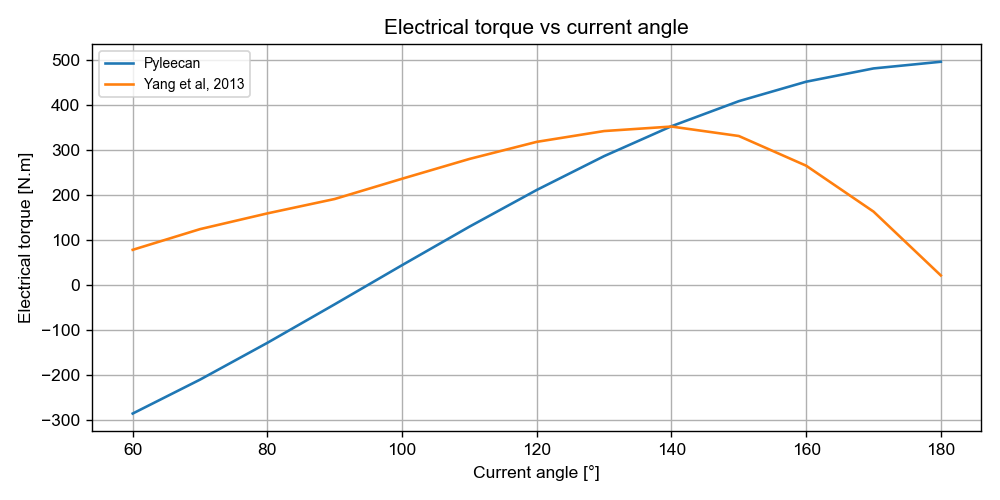

In [13]:
# Plot torque as a function of Phi0
from SciDataTool.Functions.Plot.plot_2D import plot_2D
from numpy import array

plot_2D(
    array([x*180/pi for x in Xout.xoutput_dict["Phi0"].result]),
    [Xout.xoutput_dict["Tem_av"].result, Tem_av_ref],
    legend_list=["Pyleecan", "Yang et al, 2013"],
    xlabel="Current angle [°]",
    ylabel="Electrical torque [N.m]",
    title="Electrical torque vs current angle",
)